In [41]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [42]:
'''
建立字典DATA_HUB
它可以将数据集名称的字符串映射到数据集相关的二元组上，
这个二元组包含数据集的url和验证文件完整性的sha-1密钥。
所有类似的数据集都托管在地址为`DATA_URL`的站点上。
'''
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name,cache_dir=os.path.join('..','data')):
    '''下载一个DATA_HUB中的文件，返回本地文件名。'''
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}."
    url,sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname = os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [43]:
'''
我们还需实现两个实用函数：
一个将下载并解压缩一个zip或tar文件，
另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。
'''
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [44]:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [45]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [46]:
# 训练数据集包括1460个样本，每个样本80个特征和1个标签，
# 测试数据集包含1459个样本，每个样本80个特征。
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [47]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [48]:
# 打印出训练集的前4个和后两个特征，以及最后一列的房价
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
# 测试集的
print(test_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [49]:
# 在每个样本中，第一列特征是id，需要删除
# iloc是左闭右开的
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [50]:
'''
在开始建模之前，我们需要对数据进行预处理。
首先，我们将所有缺失的值替换为相应特征的平均值。
然后，为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据
'''
# numeric_features存储数值特征的索引
# numeric_features是一个向量
# dtypes:每一列数据的格式
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)
# apply：按列执行
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [51]:
# 处理字符串
# 用独热编码来替换
# 比如我有5个不一样的值，那么我把这一列转换成五列五个feature
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [52]:
# 从pandas提取numpy格式并转为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),
                            dtype=torch.float32)

In [53]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    '''单层线性回归'''
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

均方根误差：
$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [54]:
# 用相对误差来衡量
def log_rmse(net,features,labels):
    # 将net(features)限制在[1,inf]之间
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [55]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    '''返回训练集loss和测试集loss'''
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [56]:
def get_k_fold_data(k,i,X,y):
    """准备好测试集和验证集\n
    k:表示有几个folder。i:表示第i个folder做成验证集"""
    assert k>1
    # fold_size:每个folder有几个数据
    # //:向下取整 5//2=2
    fold_size = X.shape[0] // k
    X_train,y_train = None,None
    # j表示第j个folder
    for j in range(k):
        # 比如j=0，那么就是[0,fold_size)
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)

    return X_train,y_train,X_valid,y_valid

In [57]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    """
    做k折交叉验证
    :param k:
    :param X_train:
    :param y_train:
    :param num_epochs:
    :param learning_rate:
    :param weight_decay:
    :param batch_size:
    :return:
    """
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,
                                  weight_decay,batch_size)

        # 取每一折最后一次训练的loss
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169650, 验证log rmse0.156735
折2，训练log rmse0.162218, 验证log rmse0.190974
折3，训练log rmse0.163453, 验证log rmse0.168478
折4，训练log rmse0.167407, 验证log rmse0.154479
折5，训练log rmse0.162485, 验证log rmse0.182301
5-折验证: 平均训练log rmse: 0.165042, 平均验证log rmse: 0.170593


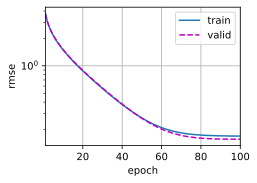

In [58]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [59]:
def train_and_pred(train_features,test_features,train_labels,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    # 不输入测试集
    train_ls,_ = train(net,train_features,train_labels,None,None,
                       num_epochs,lr,weight_decay,batch_size)

    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162342


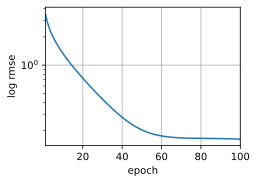

In [60]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

# 房价预测总结

In [3]:
# TODO:fill the 10 rows code to predict house price